# Flow modelling proof of concept

In [68]:
import graph_tool as gt
import graph_tool.draw
import numpy as np
import datetime
import cairo

In [2]:
print("Date:", datetime.datetime.now().date().isoformat())

Date: 2018-10-03


## Test data

In [3]:
G = gt.Graph(directed=True)
G.load("cucumba.gt")

## Flow splitting

In the GDSE, flows have two properties, *mass* [tons] and *material composition* [fraction]. In order to compute stuff in the graph, the flows (edges) need to be split per material, often resulting in paralell edges.

In [78]:
def split_flows(G):
    """Split the flows based on material composition
    
    If a flow is composed of different materials, it is split into individual flows per material 
    with the corresponding mass.
    If the flow is composed of a single material, the composition property is removed and replaced with material.
    
    Returns
    -------
    graph
        The updated graph
    eprop_material
        Edge property (materials), string
    eprop_mass
        Edge property (mass), double
    vtx_mask
        Vertex property, bool
    """
    g = G.copy()
    g.clear_edges()
    del g.edge_properties['flow']
    eprops = G.edge_properties.keys()
    mass_list = []
    material_list = []
    assert 'flow' in eprops, "The graph must have 'flow' edge property"
    e_list = []
    for e in G.edges():
        prop = G.ep.flow[e]
        assert isinstance(prop, dict), "Edge property flow must be a dictionary in edge {}".format(e)
        for material, percent in prop['composition'].items():
            e_list.append(np.array([e.source(), e.target()], dtype=int))
            mass_list.append(float(prop['mass']) * float(percent))
            material_list.append(material)
    e_array = np.vstack(e_list)
    g.add_edge_list(e_array)
    eprop_mass = g.new_edge_property("float", vals=mass_list)
    eprop_mass_text = g.new_edge_property("string", vals=[round(i,2) for i in mass_list])
    eprop_material = g.new_edge_property("string", vals=material_list)
    r = (False for x in g.get_vertices())
    vtx_mask = g.new_vertex_property("bool", vals=r)
    return (g, eprop_material, eprop_mass, eprop_mass_text, vtx_mask)

In [79]:
g_split, eprop_material, eprop_mass, eprop_mass_text, vtx_mask = split_flows(G)

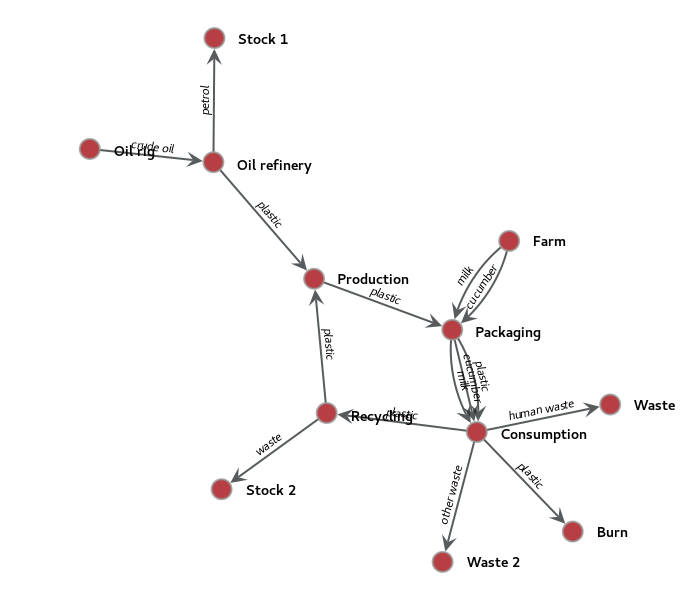

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f2811b91eb8, at 0x7f2811b63828>

In [80]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC},
                   edge_text=eprop_material,
                   output_size=(700,600), inline=True)

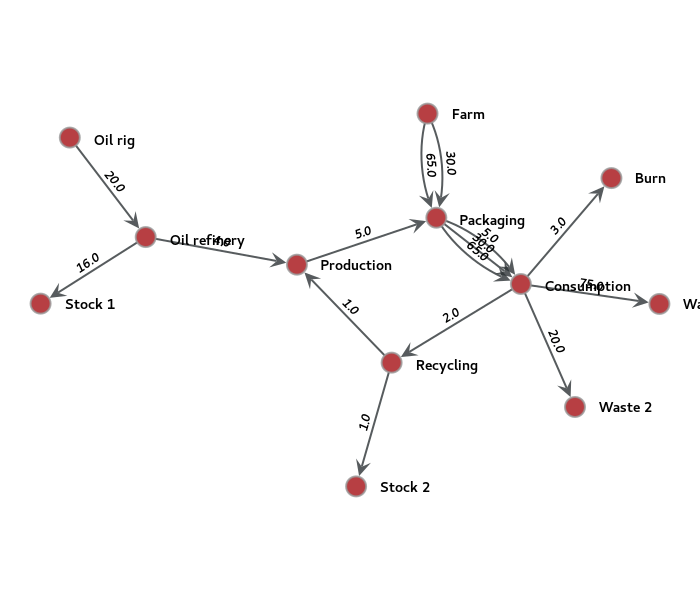

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f2811b91eb8, at 0x7f2811ccbdd8>

In [81]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "text":eprop_mass_text, "font_weight": cairo.FONT_WEIGHT_BOLD},
                   output_size=(700,600), inline=True)

## Solution 1 – plastic reduction

*Reduce the amount of plastic between Packaging and Consumption by 20% in the part of the cucumber packaging* (blue edge)

In other words:

There are 30t of cucumbers (net), plus 5% over it in plastic, thus 1,5t of plastic, between Packaging and Consumption. The solution reduces the 1,5t by 20%, thus there will be only **1,2t** of plastic (blue arrow). As an effect, the plastic-related upstream and downstream flows need to change, but the *1,2t* will stay as set manually.

In [11]:
pe = g_split.edge(g_split.vertex(1), g_split.vertex(6), all_edges=True) # the 3 edges between Packaging and Cosumption
sol_e = [e for e in pe if eprop_material[e] == 'plastic'][0] # the specific edge (blue)

In [12]:
# Now we 'implement' the solution. No need to copy the graph, just the property map
eprop_mass_sol_1_plastic = eprop_mass.copy()
# The plastic flow contains the combined mass from cucumber and milk packaging, which is 5.0t. From the 5.0t, 1,5t was
# used for cucumbers as explained above. Now, the solution reduces the packaging of cucumbers by 0.3t
print("Current combined plastic mass after Packaging:", eprop_mass_sol_1_plastic[sol_e])
solution = 0.3
eprop_mass_sol_1_plastic[sol_e] = eprop_mass[sol_e] - solution
print("Plastic mass after implementing the solution:", eprop_mass_sol_1_plastic[sol_e])

Current combined plastic mass after Packaging: 5.0
Plastic mass after implementing the solution: 4.7


#### Other solutions to test:

+ reduce packaging by 3.0t, 4.0t
+ remove packaging completely (reducy by 5.0t)

### Restricting the graph with the Solution

We need to restrict the graph to the flows that are involved in the *Solution*, otherwise flows might be altered that are not affected by the solution. For example, the solution affects the *Packaging* activity and reduces the amount of plastic packaging on cucumbers by 20%. Thus neither the amount of cucumbers nor the amount of milk should be changed.

Both the milk and cucumber *packaged product* consists of 5% plastic.

Thus the provided solution modfies the *green* edges and must not modify the *red* edges. The user is supposed to manually select the flows (green and blue edges) that are affected by the solution.

In [13]:
cols = []
sol_edges = [] # edges affected by the solution
edge_mask_1 = g_split.new_edge_property("bool")
for i, e in enumerate(g_split.edges()):
    if eprop_material[e] in ['plastic', 'crude oil']:
        cols.append("green")
        sol_edges.append(e)
        edge_mask_1[e] = True
        vtx_mask[e.source()] = True
        vtx_mask[e.target()] = True
    else:
        cols.append("red")
        edge_mask_1[e] = False
ecolors = g_split.new_edge_property("string", vals=cols)
#sol_e = sol_edges[0] # the flow/edge that is directly affected by the solution (reduction of plastic packaging).
                     # I know that is the first in the array because i checked manually for the test
ecolors[sol_e] = "blue"

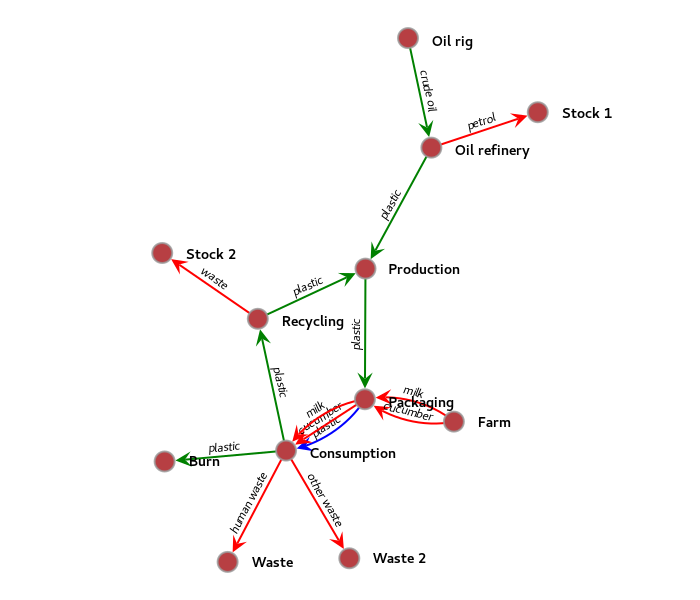

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f281c01f5f8, at 0x7f281bfdb080>

In [14]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":ecolors},
                   edge_text=eprop_material,
                   output_size=(700,600), inline=True)

Mask the edges that are not included in the solution

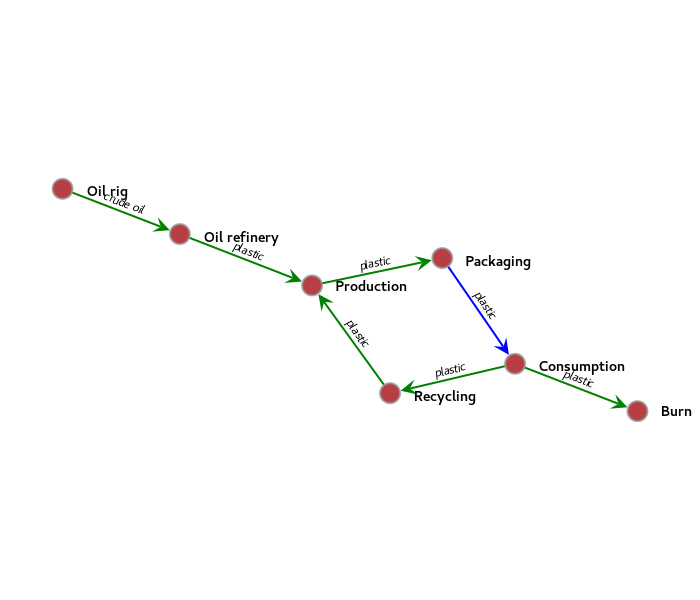

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f281c01f5f8, at 0x7f281c038550>

In [15]:
g_split.set_edge_filter(edge_mask_1)
g_split.set_vertex_filter(vtx_mask)
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":ecolors},
                   edge_text=eprop_material,
                   output_size=(700,600), inline=True)

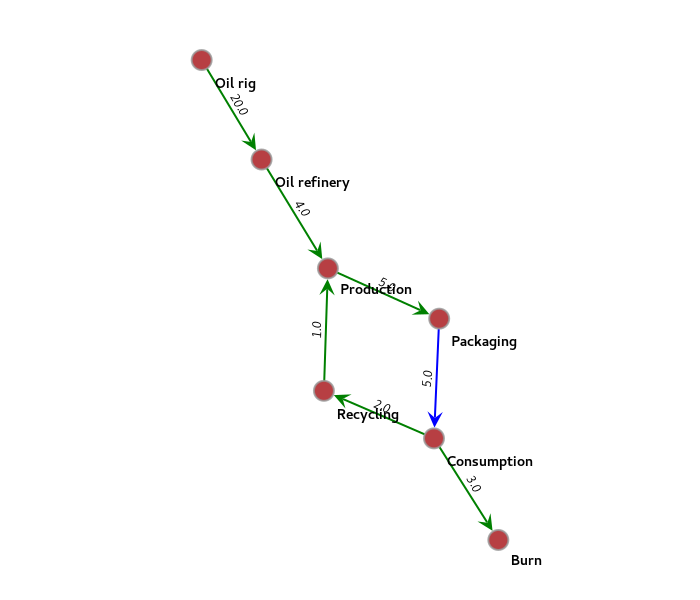

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f281c01f5f8, at 0x7f281c0388d0>

In [16]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":1, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":ecolors},
                   edge_text=eprop_mass_text,
                   output_size=(700,600), inline=True)

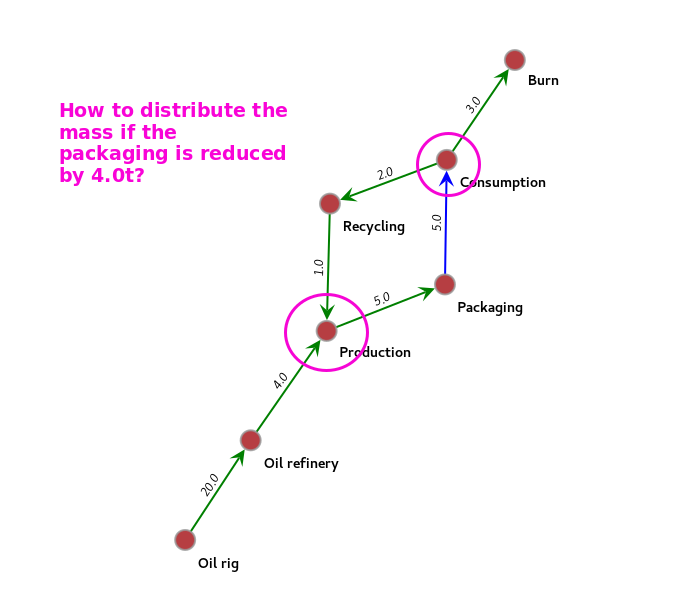

At some point when the graph was created, decisions were made on the distribution of mass in the in- and outflows at each node. We assume these decisions to be still valid. Thus when a node has multipe in- or outflows, a *contribution* factor is computed for each flow and each flow is modified according to its contribution. For example, at *Production* 4.0t (80%) comes from the *Oil refinery*, 1.0t (20%) from *Recycling*. If plastic is reduced by 4.0t in total, then the inflow from *Oil refinery* is reduced by $4.0t*0.8=3.2t$, the inflow from *Recycling* is reduced by $4.0t*0.2=0.8t$. Thus the new inflow from *Oil refinery* is 0.8t, from *Recycling* is 0.2t.

### The algorithm test

src <- get the source node of *sol_e*

all_sources <- get all the Source nodes in the graph (nodes without souce edge)

spaths <- compute all shortest paths from *src* to *all_sources*

*mass update*: the amount by which a solution modifies a flow. In this example is -0.3t

update the restricted flows along *spaths* with the *mass update*

....

Actually, probably there is no need at all for complicated graph traversal to update the flow. Once I have the correct flows isolated, they can be simply modified by the *update factor*, the result will be the same as with the 'walker' approach.

#### Alternative 1

Take the restricted graph

For each node:\
    Compute the *mass-ratio* for the in and out edges. Where $in\_mass\_ratio=\frac{mass}{total\_inflow}$ , or the same for outflows. Where the *in_mass_ratio* is assigned to the incoming edge, the *out_mass_ratio* is assigned to the outgoing edge of the node. If there is no edge then the ratio is 0.

Compute *mass update*, which is the amount by which a solution modifies a flow. In this example is -0.3t

For each edge:\
    

#### Alternative 2

Compute $balancing\_factor=\frac{solution}{solution\_flow}$ , where *solution* is the amount in *t* by which the *Solution* modifies the *solution_flow* (the *plastic* between *Packaging* and *Consumption*)

Multiply each edge in the restricted graph by the *balancing_factor*

In [17]:
bf = solution / eprop_mass[sol_e]
if bf < 1.0:
    balancing_factor = 1.0 - bf
else:
    balancing_factor = bf
print("balancing_factor:", balancing_factor)

balancing_factor: 0.94


In [18]:
eprop_mass_sol_1_plastic = g_split.new_edge_property("double", vals=eprop_mass.ma * balancing_factor) # balance the graph

In [19]:
g_split.clear_filters()
eprop_mass_sol_1_plastic = eprop_mass.copy()
eprop_mass_sol_1_plastic[sol_e] = eprop_mass[sol_e] * balancing_factor

for i,e in enumerate(g_split.edges()):
    if edge_mask_1[e]:
        src = e.source()
        if src.in_degree() > 0:
            all_in = src.in_edges()
            all_out = src.out_edges()
            s = []
            f = []
            for ein in all_in:
                s.append(eprop_mass[ein])
                if edge_mask_1[ein]:
                    f.append(eprop_mass[ein])
            sum_in = sum(s)
            flow = sum(f)
            sum_siblings_sol = sum([eprop_mass[out] for out in all_out if edge_mask_1[out]]) # sum of mass of the siblings that belong the the solution
            portion_in = flow * (eprop_mass[e] / sum_siblings_sol) # portion of incoming mass in the current edge (solution edges only)
            portion_rest = eprop_mass[e] - portion_in # the rest of the flow which does not stem from the incoming solution edge
            new_mass = ( portion_in * balancing_factor ) + portion_rest
        else:
            new_mass = eprop_mass[e] * balancing_factor
        if new_mass <= eprop_mass[e]:
            eprop_mass_sol_1_plastic[e] = -1 * (eprop_mass[e] - new_mass)
        else:
            eprop_mass_sol_1_plastic[e] = new_mass - eprop_mass[e]       
    else:
        eprop_mass_sol_1_plastic[e] = 0

**The new flows:**

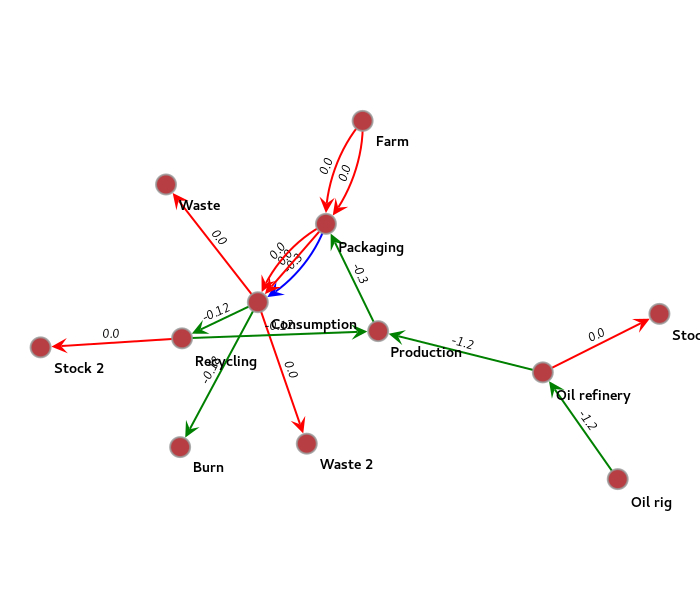

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f281c01f5f8, at 0x7f281bfdb710>

In [20]:
eprop_mass_text_sol = g_split.new_edge_property("string", vals=[round(i,2) for i in eprop_mass_sol_1_plastic])
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":1, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":ecolors},
                   edge_text=eprop_mass_text_sol,
                   output_size=(700,600), inline=True)

## Solution 2 – milk reduction

*Reduce milk production by 40%*

The current milk production is $0.6842*95=65t$ , after implementing the solution it will be reduced by 26t. Thus the __*balancing_factor* for milk is 0.6__.

Milk is also packaged in plastic, which is *5.4%* ( 3.5/65=0.054 ) over the net mass of the milk. Reducing the milk also reduces the plastic, thus at the end we'll end up with $(65t * 0.6) * 0.054 = 2.106t$ of plastic packaging for the milk. Thus the __*balancing_factor* for plastic is__ 2.106/3.5=__0.6017__ 

In [21]:
g_split.clear_filters() # remove the edge and vertex masks

In [22]:
pe = g_split.edge(g_split.vertex(0), g_split.vertex(1), all_edges=True) # the 2 edges between Farm and Packaging
sol_e = [e for e in pe if eprop_material[e] == 'milk'][0] # the specific edge (blue)

print("Current milk mass after Farm", round(eprop_mass[sol_e],2))
solution = 26
sol_mass = eprop_mass[sol_e] - solution
print("Milk mass after implementing the solution", round(sol_mass,2))

Current milk mass after Farm 65.0
Milk mass after implementing the solution 39.0


The flows affected by the solution are manually selected by the user.

In [23]:
# reset masks
for e in g_split.edges():
    #edge_mask[e] = False
    vtx_mask[e.source()] = False
    vtx_mask[e.target()] = False

cols = []
sol_edges = [] # edges affected by the solution
edge_mask_2 = g_split.new_edge_property("bool")
for i, e in enumerate(g_split.edges()):
    if eprop_material[e] in ['milk', 'human waste', 'other waste']:
        cols.append("green")
        sol_edges.append(e)
        edge_mask_2[e] = True
        vtx_mask[e.source()] = True
        vtx_mask[e.target()] = True
    else:
        cols.append("red")
        edge_mask_2[e] = False
ecolors = g_split.new_edge_property("string", vals=cols)
ecolors[sol_e] = "blue"

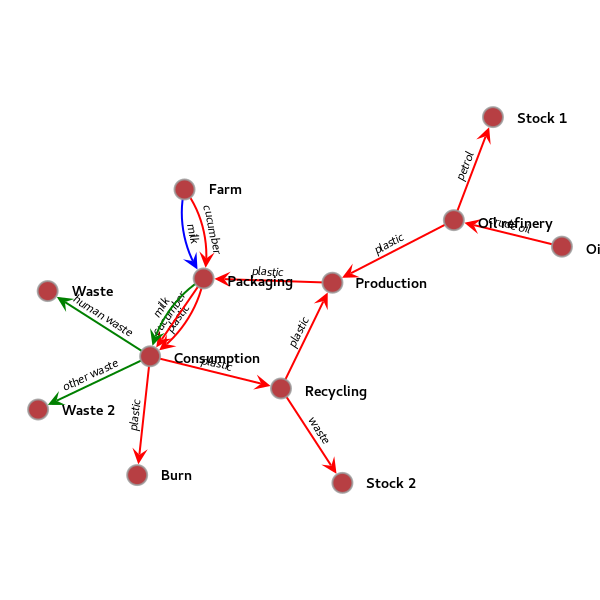

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f281c01f5f8, at 0x7f281c03fd30>

In [24]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":ecolors},
                   edge_text=eprop_material, inline=True)

In [25]:
g_split.set_edge_filter(edge_mask_2)
g_split.set_vertex_filter(vtx_mask)

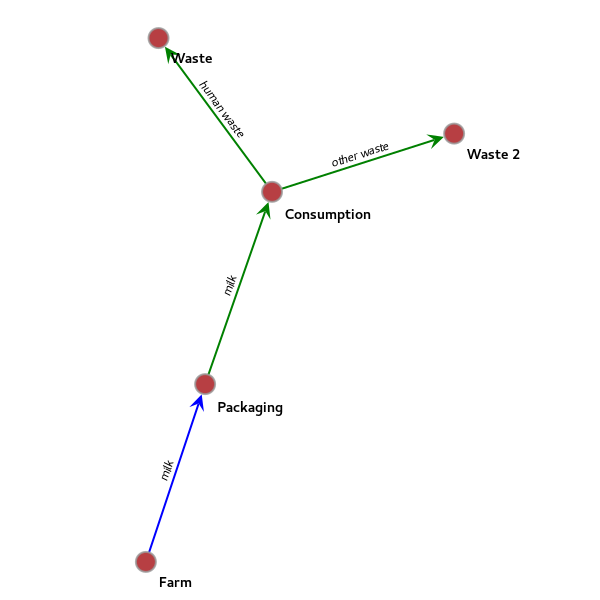

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f281c01f5f8, at 0x7f281c03fe80>

In [26]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":1, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":ecolors},
                   edge_text=eprop_material, inline=True)

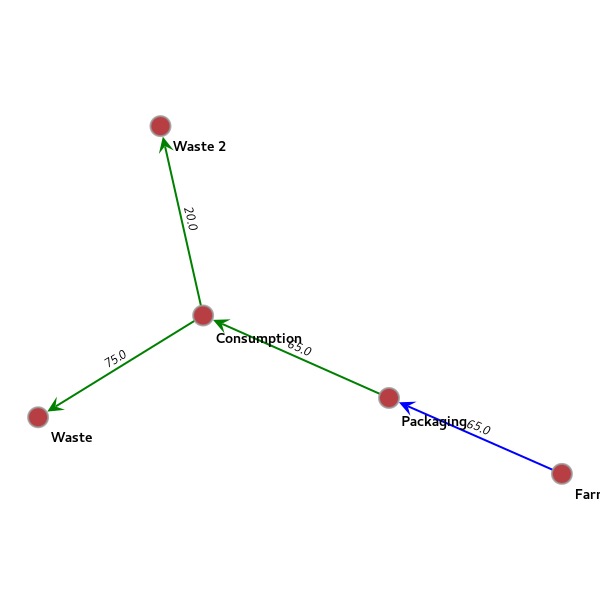

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f281c01f5f8, at 0x7f281c03fef0>

In [27]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":1, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":ecolors},
                   edge_text=eprop_mass_text, inline=True)

The flow between *Consumption* and *Waste* has a different material (human waste, other waste) than milk. Because this flow (human waste, other waste) doesn't have a composition, we need to calcuate the ratio of milk in it.

### Mass calculation method

We have:

$current\_flow$ is the mass of the current edge 

$sum\_siblings$ is the sum of all flows that have the same origin as $current\_flow$ and that are part of the solution

$sum\_inflows$ is the sum of all inflows to the origin of $current\_flow$ and that are part of the solution

Then we can compute:

$$portion\_in = sum\_inflows * (\frac{current\_flow}{sum\_siblings})$$

$$portion\_rest = current\_flow - portion\_in$$

Where $portion\_in$ is the portion of incoming mass in the current flow (solution flows only), $portion\_rest$ is the rest of the flow which does not stem from the incoming flow that is used for calcuating $portion\_in$.

And finally obtain the adjusted flow as:

$$ new\_mass = ( portion\_in * balancing\_factor ) + portion\_rest $$



In [28]:
g_split.clear_filters()
eprop_mass_sol_2_milk = eprop_mass.copy()
balancing_factor = 0.6
eprop_mass_sol_2_milk[sol_e] = eprop_mass_sol_2_milk[sol_e] * balancing_factor

for i,e in enumerate(g_split.edges()):
    if edge_mask_2[e]:
        src = e.source()
        if src.in_degree() > 0:
            all_in = src.in_edges()
            all_out = src.out_edges()
            s = []
            f = []
            for ein in all_in:
                s.append(eprop_mass[ein])
                if edge_mask_2[ein]:
                    f.append(eprop_mass[ein])
            sum_in = sum(s)
            flow = sum(f)
            sum_siblings_sol = sum([eprop_mass[out] for out in all_out if edge_mask_2[out]]) # sum of mass of the siblings that belong the the solution
            portion_in = flow * (eprop_mass[e] / sum_siblings_sol) # portion of incoming mass in the current edge (solution edges only)
            portion_rest = eprop_mass[e] - portion_in # the rest of the flow which does not stem from the incoming solution edge
            new_mass = ( portion_in * balancing_factor ) + portion_rest
        else:
            new_mass = eprop_mass[e] * balancing_factor
        if new_mass <= eprop_mass[e]:
            eprop_mass_sol_2_milk[e] = -1 * (eprop_mass[e] - new_mass)
        else:
            eprop_mass_sol_2_milk[e] = new_mass - eprop_mass[e]       
    else:
        eprop_mass_sol_2_milk[e] = 0

eprop_mass_sol_text = g_split.new_edge_property("string", vals=[round(i,2) for i in eprop_mass_sol_2_milk])

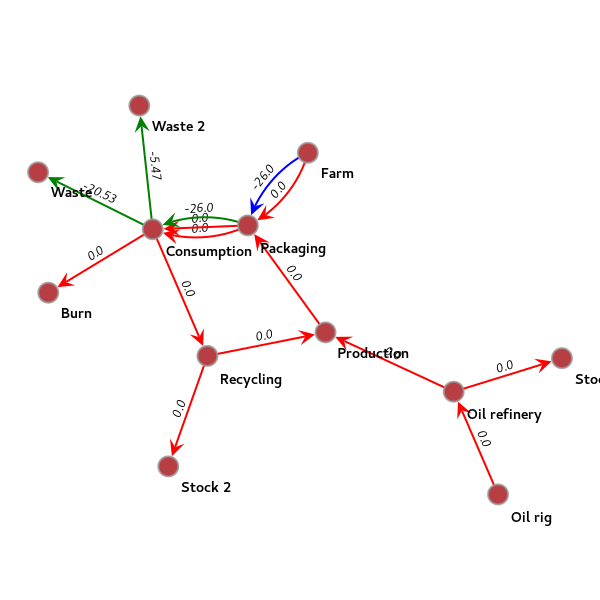

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f281c01f5f8, at 0x7f281bff0358>

In [29]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":1, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":ecolors},
                   edge_text=eprop_mass_sol_text, inline=True)

In [30]:
g_split.set_edge_filter(edge_mask_2)
g_split.set_vertex_filter(vtx_mask)

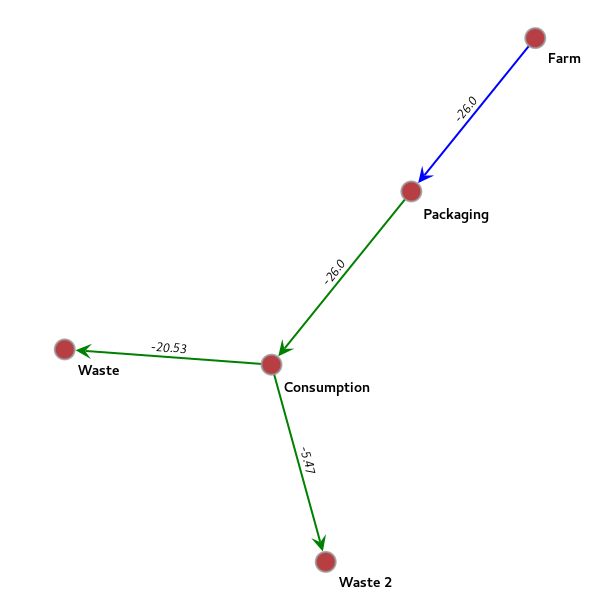

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f281c01f5f8, at 0x7f281bff0780>

In [31]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":1, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":ecolors},
                   edge_text=eprop_mass_sol_text, inline=True)

### Compute for the plastic part

Let's compute our expectation for the plastic reduction.

In [32]:
g_split.clear_filters() # remove the edge and vertex masks
pe = g_split.edge(g_split.vertex(1), g_split.vertex(6), all_edges=True) # the 3 edges between Packaging and Cosumption
sol_e = [e for e in pe if eprop_material[e] == 'plastic'][0] # the specific edge (blue)

eprop_mass_sol_2_plastic = eprop_mass.copy()
print("Current combined plastic mass after Packaging:", eprop_mass_sol_2_plastic[sol_e])

solution = 0.6017 #Solution-2-–-milk-reduction
print("Solution reduces the plastic mass by:", solution, "on the solution edge")

eprop_mass_sol_2_plastic[sol_e] = eprop_mass_sol_2_plastic[sol_e] - solution
print("Plastic mass of the solution edge after implementing the solution:", eprop_mass_sol_2_plastic[sol_e])

cols = []
sol_edges = [] # edges affected by the solution
edge_mask_3 = g_split.new_edge_property("bool")
for i, e in enumerate(g_split.edges()):
    if eprop_material[e] in ['plastic', 'crude oil']:
        cols.append("green")
        sol_edges.append(e)
        edge_mask_3[e] = True
        vtx_mask[e.source()] = True
        vtx_mask[e.target()] = True
    else:
        cols.append("red")
        edge_mask_3[e] = False
ecolors = g_split.new_edge_property("string", vals=cols)

ecolors[sol_e] = "blue"

Current combined plastic mass after Packaging: 5.0
Solution reduces the plastic mass by: 0.6017 on the solution edge
Plastic mass of the solution edge after implementing the solution: 4.3983


In [33]:
eprop_mass_sol_2_plastic = eprop_mass.copy()

bf = solution / eprop_mass[sol_e]
if bf < 1.0:
    balancing_factor = 1.0 - bf
else:
    balancing_factor = bf
print("The balancing_factor for all plastic edges:", balancing_factor)

eprop_mass_sol_2_plastic[sol_e] = eprop_mass_sol_2_plastic[sol_e] * balancing_factor

for i,e in enumerate(g_split.edges()):
    if edge_mask_3[e]:
        src = e.source()
        if src.in_degree() > 0:
            all_in = src.in_edges()
            all_out = src.out_edges()
            s = []
            f = []
            for ein in all_in:
                s.append(eprop_mass[ein])
                if edge_mask_3[ein]:
                    f.append(eprop_mass[ein])
            sum_in = sum(s)
            flow = sum(f)
            sum_siblings_sol = sum([eprop_mass[out] for out in all_out if edge_mask_3[out]]) # sum of mass of the siblings that belong the the solution
            portion_in = flow * (eprop_mass[e] / sum_siblings_sol) # portion of incoming mass in the current edge (solution edges only)
            portion_rest = eprop_mass[e] - portion_in # the rest of the flow which does not stem from the incoming solution edge
            new_mass = ( portion_in * balancing_factor ) + portion_rest
        else:
            new_mass = eprop_mass[e] * balancing_factor
        if new_mass <= eprop_mass[e]:
            eprop_mass_sol_2_plastic[e] = -1 * (eprop_mass[e] - new_mass)
        else:
            eprop_mass_sol_2_plastic[e] = new_mass - eprop_mass[e]       
    else:
        eprop_mass_sol_2_plastic[e] = 0

eprop_mass_sol_text = g_split.new_edge_property("string", vals=[round(i,2) for i in eprop_mass_sol_2_plastic])

The balancing_factor for all plastic edges: 0.87966


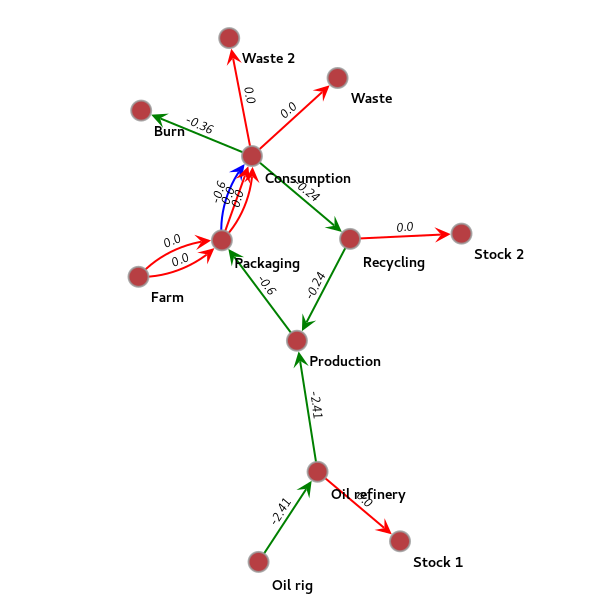

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f281c01f5f8, at 0x7f281bff05c0>

In [34]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":1, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":ecolors},
                   edge_text=eprop_mass_sol_text, inline=True)

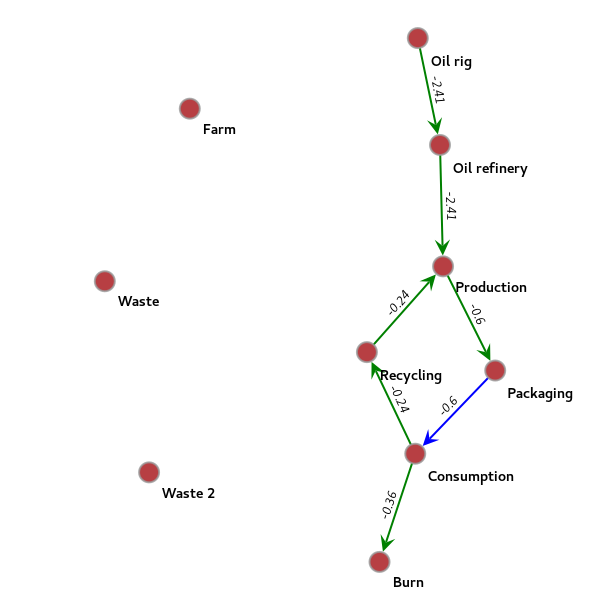

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f281c01f5f8, at 0x7f281bfdbe80>

In [35]:
g_split.set_edge_filter(edge_mask_3)
g_split.set_vertex_filter(vtx_mask)

gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":1, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":ecolors},
                   edge_text=eprop_mass_sol_text, inline=True)

## Combining solutions or solution-parts

A **solution** is defined by
1. amount of change
2. affected material
3. the edge on which the solution is applied

**Solution-graph**: A subset of the graph/system containing only the edges that are affected by the solution and on which a solution has been already applied, thus the flows have been altered.

**Solution-part**: A solution can have several parts in case the desired change in a material results in changes in other materials. For example reducing the milk production also reduces the plastic production.

Once we computed the solution-parts for the milk and for the plastic, we need to integrate both into a single graph which then represents *the* complete solution. In a similar fashion, it should be possible to combine solutions that are part of a strategy.

The straightforward approach is to sum up the mass changes of each solution graph. In which case:

    for each edge:

        final mass = original mass + solution 1 + ... + solution n
        
But this requires that solution_n is the signed amount of change in mass for a particular edge, not the amount after applying the solution.

In [36]:
g_split.clear_filters() # remove the edge and vertex masks

In [52]:
for i,e in enumerate(g_split.edges()):
    formula = "{eid}    {omass} + {s1}[mask {m1}] + {s2}[mask {m2}] + {s3}[mask {m3}] = {res}    change: {ch}t {mat}".format(
        eid=i, omass=eprop_mass[e],
        s1=round(eprop_mass_sol_1_plastic[e],2), s2=round(eprop_mass_sol_2_milk[e],2), 
        s3=round(eprop_mass_sol_2_plastic[e],2), m1=edge_mask_1[e], m2=edge_mask_2[e], m3=edge_mask_3[e],
        res=round(eprop_mass[e] + eprop_mass_sol_1_plastic[e] + eprop_mass_sol_2_milk[e] + eprop_mass_sol_2_plastic[e], 2),
        ch=round(sum([eprop_mass_sol_1_plastic[e],eprop_mass_sol_2_milk[e],eprop_mass_sol_2_plastic[e]]), 2),
        mat=eprop_material[e]
    )
    print(formula)
#    print(i,
#          edge_mask_1[e],":",round(eprop_mass_sol_1_plastic[e],2),
#          edge_mask_2[e],":",round(eprop_mass_sol_2_milk[e],2),
#          edge_mask_3[e],":",round(eprop_mass_sol_2_plastic[e],2))

0    30.001 + 0.0[mask 0] + 0.0[mask 0] + 0.0[mask 0] = 30.0    change: 0.0t cucumber
1    64.99900000000001 + 0.0[mask 0] + -26.0[mask 1] + 0.0[mask 0] = 39.0    change: -26.0t milk
2    5.0 + -0.3[mask 1] + 0.0[mask 0] + -0.6[mask 1] = 4.1    change: -0.9t plastic
3    30.0 + 0.0[mask 0] + 0.0[mask 0] + 0.0[mask 0] = 30.0    change: 0.0t cucumber
4    65.0 + 0.0[mask 0] + -26.0[mask 1] + 0.0[mask 0] = 39.0    change: -26.0t milk
5    20.0 + -1.2[mask 1] + 0.0[mask 0] + -2.41[mask 1] = 16.39    change: -3.61t crude oil
6    16.0 + 0.0[mask 0] + 0.0[mask 0] + 0.0[mask 0] = 16.0    change: 0.0t petrol
7    4.0 + -1.2[mask 1] + 0.0[mask 0] + -2.41[mask 1] = 0.39    change: -3.61t plastic
8    5.0 + -0.3[mask 1] + 0.0[mask 0] + -0.6[mask 1] = 4.1    change: -0.9t plastic
9    75.0 + 0.0[mask 0] + -20.53[mask 1] + 0.0[mask 0] = 54.47    change: -20.53t human waste
10    3.0 + -0.18[mask 1] + 0.0[mask 0] + -0.36[mask 1] = 2.46    change: -0.54t plastic
11    2.0 + -0.12[mask 1] + 0.0[mask 0

In [72]:
from pprint import pformat

In [76]:
for i,e in enumerate(g_split.edges()):
    formula = "{eid}    {src} --> {dst}    change:  {ch}t  {mat}".format(
        eid=i, src=g_split.vp.id[e.source()], dst=g_split.vp.id[e.target()], mat=eprop_material[e], 
        ch=round(sum([eprop_mass_sol_1_plastic[e],eprop_mass_sol_2_milk[e],eprop_mass_sol_2_plastic[e]]), 2)
    )
    print("")
    print(formula)


0    Farm --> Packaging    change:  0.0t  cucumber

1    Farm --> Packaging    change:  -26.0t  milk

2    Packaging --> Consumption    change:  -0.9t  plastic

3    Packaging --> Consumption    change:  0.0t  cucumber

4    Packaging --> Consumption    change:  -26.0t  milk

5    Oil rig --> Oil refinery    change:  -3.61t  crude oil

6    Oil refinery --> Stock 1    change:  0.0t  petrol

7    Oil refinery --> Production    change:  -3.61t  plastic

8    Production --> Packaging    change:  -0.9t  plastic

9    Consumption --> Waste    change:  -20.53t  human waste

10    Consumption --> Burn    change:  -0.54t  plastic

11    Consumption --> Recycling    change:  -0.36t  plastic

12    Consumption --> Waste 2    change:  -5.47t  other waste

13    Recycling --> Stock 2    change:  0.0t  waste

14    Recycling --> Production    change:  -0.36t  plastic
